# Translation with a Sequence to Sequence Network and Attention

In this tutorial, we will translate from French to English using a Seq2Seq network.

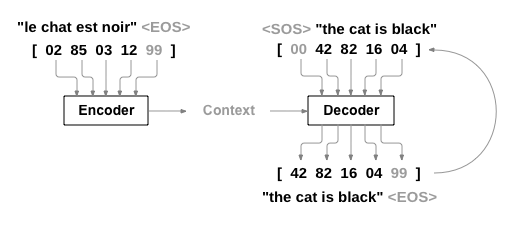

In [5]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Preparation

Similar to the character encoding used in the character-level RNN tutorials, we will be representing each word in a language as a one-hot vector, or giant vector of zeros except for a single one.

In [6]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [7]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [8]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('names-data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

There is a lot of data so for example sake we on use the examples with 10 or less words.

In [9]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

1. Read text file and split into lines, split lines into pairs
2. Normalize text, filter by length and content

3. Make word lists from sentences in pairs

In [10]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
['c est un bon etudiant', 'he is a good student']


## The Seq2Seq Model

-> A model consisting of two RNNs, called an Encoder and Decoder

The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence.

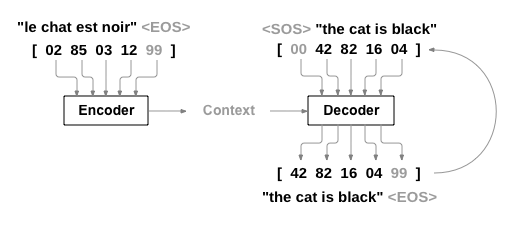

Unlike sequence prediction with a single RNN, where every input corresponds to an output, the seq2seq model frees us from sequence length and order, which makes it ideal for translation between two languages.

Consider the sentence `Je ne suis pas le chat noir → I am not the black cat`. Most of the words in the input sentence have a direct translation in the output sentence, but are in slightly different orders, e.g. `chat noir` and `black cat`. Because of the ne/pas construction there is also one more word in the input sentence. It would be difficult to produce a correct translation directly from the sequence of input words.

With a seq2seq model the encoder creates a single vector which, in the ideal case, encodes the “meaning” of the input sequence into a single vector — a single point in some N dimensional space of sentences.

### The Encoder

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

### The Decoder

The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.

In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string `<SOS>` token, and the first hidden state is the context vector (the encoder’s last hidden state).

In [12]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

#### Decoder with Attention

If only the context vector is passed between the encoder and decoder, that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called attn_applied in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

In [13]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

## Training

#### Preparing the Data

To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.

In [14]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

#### Training the Model

To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the `<SOS>` token as its first input, and the last hidden state of the encoder as its first hidden state.

“Teacher forcing” is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to converge faster but when the trained network is exploited, it may exhibit instability.

In [15]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.

In [16]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

- Start a timer 
- Initialise optimisers and criterion
- Create a set of training pairs 
- Start empty losses array for plotting 

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
matplotlib.use("agg")
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [18]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001, 
          print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(plot_losses)

## Evaluation 

In [19]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [20]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Train and Test

In [21]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
0m 39s (- 9m 53s) (5 6%) 1.5210
1m 16s (- 8m 57s) (10 12%) 0.6687
1m 54s (- 8m 14s) (15 18%) 0.3439
2m 31s (- 7m 33s) (20 25%) 0.1914
3m 8s (- 6m 54s) (25 31%) 0.1200
3m 45s (- 6m 15s) (30 37%) 0.0850
4m 22s (- 5m 37s) (35 43%) 0.0652
4m 59s (- 4m 59s) (40 50%) 0.0526
5m 36s (- 4m 22s) (45 56%) 0.0457
6m 13s (- 3m 44s) (50 62%) 0.0415
6m 50s (- 3m 6s) (55 68%) 0.0374
7m 27s (- 2m 29s) (60 75%) 0.0348
8m 4s (- 1m 51s) (65 81%) 0.0330
8m 41s (- 1m 14s) (70 87%) 0.0312
9m 18s (- 0m 37s) (75 93%) 0.0302
9m 55s (- 0m 0s) (80 100%) 0.0285


In [22]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> je suis pret !
= i m ready !
< i m ready ! <EOS>

> vous etes chanceux
= you re fortunate
< you re fortunate <EOS>

> je n ai pas fini
= i m not done
< i m not done <EOS>

> je n y suis pas tres bon
= i m not very good at it
< i m not very good at it <EOS>

> je suis desole mon pere n est pas la
= i m sorry my father s not here
< i m sorry my father s not here <EOS>

> vous etes fort avise
= you re very wise
< you re very wise <EOS>

> j ai hate que les vacances d ete arrivent
= i m looking forward to the summer vacation
< i m looking forward to the summer vacation <EOS>

> elle est vraiment passionnee de tricot
= she is really into knitting
< she is really into knitting <EOS>

> nous avons presque acheve ce travail
= we re just about finished with this job
< we re just about finished with this job <EOS>

> elle est sympa avec tout le monde
= she is friendly to everybody
< she is friendly to everybody <EOS>



## Visualising Attention

In [23]:
import matplotlib
matplotlib.use("Qt5Agg")

def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateAndShowAttention('il n est pas aussi grand que son pere')

evaluateAndShowAttention('je suis trop fatigue pour conduire')

evaluateAndShowAttention('je suis desole si c est une question idiote')

evaluateAndShowAttention('je suis reellement fiere de vous')


input = il n est pas aussi grand que son pere
output = he is not as tall as his father <EOS>


C:\Users\richa\AppData\Local\Temp\ipykernel_17296\3558430884.py:2: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed two minor releases later.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use("Qt5Agg")
C:\Users\richa\AppData\Local\Temp\ipykernel_17296\3558430884.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\richa\AppData\Local\Temp\ipykernel_17296\3558430884.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


input = je suis trop fatigue pour conduire
output = i m too tired to drive <EOS>


C:\Users\richa\AppData\Local\Temp\ipykernel_17296\3558430884.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\richa\AppData\Local\Temp\ipykernel_17296\3558430884.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


input = je suis desole si c est une question idiote
output = i m sorry if this is a stupid question <EOS>


C:\Users\richa\AppData\Local\Temp\ipykernel_17296\3558430884.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\richa\AppData\Local\Temp\ipykernel_17296\3558430884.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


input = je suis reellement fiere de vous
output = i m really proud of you guys <EOS>


C:\Users\richa\AppData\Local\Temp\ipykernel_17296\3558430884.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\richa\AppData\Local\Temp\ipykernel_17296\3558430884.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


## References
- https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
- https://github.com/spro/practical-pytorch/tree/master/seq2seq-translation